In [23]:
import argparse
import datetime
import os
import traceback
import cv2
import numpy as np
import torch
import yaml
from torch import nn
from torch.utils.data import DataLoader
from torchvision import transforms
from tqdm.autonotebook import tqdm
from glob import glob
from backbone import EfficientDetBackbone
from efficientdet.dataset import HmDataset, Resizer, Normalizer, Augmenter, collater, get_bbox
from efficientdet.loss import FocalLoss
from utils.sync_batchnorm import patch_replication_callback
from utils.utils import replace_w_sync_bn, CustomDataParallel, get_last_weights, init_weights, boolean_string
from efficientdet.utils import BBoxTransform, ClipBoxes
from utils.utils import preprocess, invert_affine, postprocess
from torch.backends import cudnn
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import PIL.Image as Image
from tensorboardX import SummaryWriter
from mean_average_precision import MeanAveragePrecision
import seaborn as sns
import csv
import warnings
import math
warnings.filterwarnings(action='ignore')
%matplotlib inline
#torch.autograd.set_detect_anomaly(True)

# Hyperparameter

In [2]:
opt = {
    'project':'hemorrhage',
    'compound_coef':0,
    'num_workers':12,
    'batch_size':12*torch.cuda.device_count(),
    'test_batch_size':1,
    'head_only':False,
    'lr':1e-3,
    'optim':'adamw',
    'num_epochs':600,
    'val_interval':1,
    'save_interval':1000,
    'es_min_delta':0.0,
    'es_patience':0.0,
    'data_path':'../Hemorrhage_dataset/',
    'log_path':'logs/',
    'load_weights':'weights/efficientdet-d0.pth',
    'saved_path':'logs/',
    'debug':False,
}

class Params:
    def __init__(self, project_file):
        self.params = yaml.safe_load(open(project_file).read())

    def __getattr__(self, item):
        return self.params.get(item, None)

params = Params(f'projects/'+opt['project']+'.yml')

if params.num_gpus == 0:
    os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
else:
    torch.manual_seed(42)

opt['saved_path'] = opt['saved_path'] + f'/{params.project_name}/'
opt['log_path'] = opt['log_path'] + f'/{params.project_name}/tensorboard/'
os.makedirs(opt['log_path'], exist_ok=True)
os.makedirs(opt['saved_path'], exist_ok=True)

training_params = {'batch_size': opt['batch_size'],
                   'shuffle': True,
                   'drop_last': True,
                   'collate_fn': collater,
                   'num_workers': opt['num_workers']}

val_params = {'batch_size': opt['batch_size'],
              'shuffle': False,
              'drop_last': True,
              'collate_fn': collater,
              'num_workers': opt['num_workers']}

test_params = {'batch_size': opt['test_batch_size'],
              'shuffle': False,
              'drop_last': True,
              'collate_fn': collater,
              'num_workers': opt['num_workers']}

input_sizes = [512, 640, 768, 896, 1024, 1280, 1280, 1536, 1536]

# Utils

In [3]:
class ModelWithLoss(nn.Module):
    def __init__(self, model, debug=False):
        super().__init__()
        self.criterion = FocalLoss()
        self.model = model
        self.debug = debug

    def forward(self, imgs, annotations, obj_list=None):
        _, regression, classification, anchors = self.model(imgs)
        if self.debug:
            cls_loss, reg_loss = self.criterion(classification, regression, anchors, annotations,
                                                imgs=imgs, obj_list=obj_list)
        else:
            cls_loss, reg_loss = self.criterion(classification, regression, anchors, annotations)
        return cls_loss, reg_loss

def save_checkpoint(model, name):
    if isinstance(model, CustomDataParallel):
        torch.save(model.module.model.state_dict(), os.path.join(opt['saved_path'], name))
    else:
        torch.save(model.model.state_dict(), os.path.join(opt['saved_path'], name))

In [4]:
def visualization(img_path, weight_path=opt['load_weights'], threshold=0.2, iou_threshold=0.2):
    
    # Bounding-box colors
    cmap = plt.get_cmap("tab20b")
    colors = [cmap(i) for i in np.linspace(0, 1, len(params.obj_list))]

    fig, ax0 = plt.subplots(figsize=(5,5))
    
    cudnn.fastest = True
    cudnn.benchmark = True

    # tf bilinear interpolation is different from any other's, just make do
    input_size = input_sizes[opt['compound_coef']]
    ori_imgs, framed_imgs, framed_metas = preprocess(img_path, max_size=input_size, mean=params.mean, std=params.std)
    
    if torch.cuda.is_available():
        x = torch.stack([torch.from_numpy(fi).cuda() for fi in framed_imgs], 0)
    else:
        x = torch.stack([torch.from_numpy(fi) for fi in framed_imgs], 0)

    x = x.to(torch.float32).permute(0, 3, 1, 2)

    model_eval = EfficientDetBackbone(num_classes=len(params.obj_list), compound_coef=opt['compound_coef'],
                                 ratios=eval(params.anchors_ratios), scales=eval(params.anchors_scales))
    
    try:
        model_eval.load_state_dict(torch.load(weight_path))
    except:
        print('The rest of the weights should be loaded already.')
        
    model_eval.requires_grad_(False)
    model_eval.eval()

    if torch.cuda.is_available():
        model_eval = model_eval.cuda()

    with torch.no_grad():
        features, regression, classification, anchors = model_eval(x)

        regressBoxes = BBoxTransform()
        clipBoxes = ClipBoxes()

        out = postprocess(x,
                          anchors, regression, classification,
                          regressBoxes, clipBoxes,
                          threshold, iou_threshold)

    out = invert_affine(framed_metas, out)

    for i in range(len(ori_imgs)):
        if len(out[i]['rois']) == 0:
            continue
        ori_imgs[i] = ori_imgs[i].copy()
        for j in range(len(out[i]['rois'])):
            (x1, y1, x2, y2) = out[i]['rois'][j].astype(np.int)
            obj = params.obj_list[out[i]['class_ids'][j]]
            score = float(out[i]['scores'][j])
                       
            color = colors[out[i]['class_ids'][j]]
            bbox = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=2, edgecolor=color, facecolor="none")
            
            ax0.add_patch(bbox)
            # Add label
            ax0.text(
                x1,
                y2,
                s="{} {:.3f}".format(obj,score),
                color="white",
                verticalalignment="top", 
                bbox={"color": color, "pad": 0},   
            )

    ax0.imshow(ori_imgs[i])
    ax0.axis("off")

In [5]:
def save_result(image_paths, number, weight_path=opt['load_weights'], threshold=0.2, iou_threshold=0.2):
    # Bounding-box colors
    for num in range(0,number):
        img_path = image_paths[num]

        cmap = plt.get_cmap("tab20b")
        colors = [cmap(i) for i in np.linspace(0, 1, len(params.obj_list))]

        fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(12,12))

        cudnn.fastest = True
        cudnn.benchmark = True

        # tf bilinear interpolation is different from any other's, just make do
        input_size = input_sizes[opt['compound_coef']]
        ori_imgs, framed_imgs, framed_metas = preprocess(img_path, max_size=input_size, mean=params.mean, std=params.std)

        if torch.cuda.is_available():
            x = torch.stack([torch.from_numpy(fi).cuda() for fi in framed_imgs], 0)
        else:
            x = torch.stack([torch.from_numpy(fi) for fi in framed_imgs], 0)

        x = x.to(torch.float32).permute(0, 3, 1, 2)

        model_eval = EfficientDetBackbone(num_classes=len(params.obj_list), compound_coef=opt['compound_coef'],
                                     ratios=eval(params.anchors_ratios), scales=eval(params.anchors_scales))

        try:
            model_eval.load_state_dict(torch.load(weight_path))
        except:
            print('The rest of the weights should be loaded already.')

        model_eval.requires_grad_(False)
        model_eval.eval()

        if torch.cuda.is_available():
            model_eval = model_eval.cuda()

        with torch.no_grad():
            features, regression, classification, anchors = model_eval(x)

            regressBoxes = BBoxTransform()
            clipBoxes = ClipBoxes()

            out = postprocess(x,
                              anchors, regression, classification,
                              regressBoxes, clipBoxes,
                              threshold, iou_threshold)

        out = invert_affine(framed_metas, out)

        for i in range(len(ori_imgs)):
            if len(out[i]['rois']) == 0:
                continue
            ori_imgs[i] = ori_imgs[i].copy()
            for j in range(len(out[i]['rois'])):
                (x1, y1, x2, y2) = out[i]['rois'][j].astype(np.int)
                obj = params.obj_list[out[i]['class_ids'][j]]
                score = float(out[i]['scores'][j])

                color = colors[out[i]['class_ids'][j]]
                bbox = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=2, edgecolor=color, facecolor="none")

                ax0.add_patch(bbox)
                # Add label
                ax0.text(
                    x1,
                    y2,
                    s="{} {:.3f}".format(obj,score),
                    color="white",
                    verticalalignment="top", 
                    bbox={"color": color, "pad": 0},   
                )
        # Get specific val images
        data = test_set.__getitem__(num) # Convert to 4d tensor (BxNxHxW)
        test_image = data['img'].unsqueeze(0)
        test_image = ((test_image - test_image.min()) / (test_image.max() - test_image.min()))

        for i in range(0,data['annot'].shape[0]):
            [x1,y1,x2,y2,cls] = data['annot'][i].numpy()
            color = colors[int(cls)]
            bbox = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=2, edgecolor=color, facecolor="none")
            ax1.add_patch(bbox)
            # Add label
            ax1.text(
                x1,
                y2,
                s=params.obj_list[int(cls)],
                color="white",
                verticalalignment="top", 
                bbox={"color": color, "pad": 0},   
            )

        ax0.imshow(ori_imgs[0])
        ax0.set_title('Prediction')
        ax0.axis('off')
        ax1.imshow(test_image[0])
        ax1.set_title('Ground truth')
        ax1.axis('off')
        fig.savefig('./test/hemorrhage/result_{}'.format(num))

In [6]:
def eval_bbox(image_paths, mask_paths, weight_path=opt['load_weights'], cls_num=1, threshold=0.2, iou_threshold=0.2):
    
    # create metric_fn
    metric_fn = MeanAveragePrecision(num_classes=len(params.obj_list))
    
    cudnn.fastest = True
    cudnn.benchmark = True

    model_eval = EfficientDetBackbone(num_classes=len(params.obj_list), compound_coef=opt['compound_coef'],
                                 ratios=eval(params.anchors_ratios), scales=eval(params.anchors_scales))
    
    try:
        model_eval.load_state_dict(torch.load(weight_path))
    except:
        print('The rest of the weights should be loaded already.')
        
    model_eval.requires_grad_(False)
    model_eval.eval()

    if torch.cuda.is_available():
        model_eval = model_eval.cuda()  
    
    # tf bilinear interpolation is different from any other's, just make do
    input_size = input_sizes[opt['compound_coef']]
    
    step = 1
    
    with torch.no_grad():
        for image_path, mask_path in zip(image_paths, mask_paths):
            
            
            preds = np.zeros((0,6))
            gts = np.zeros((0,7))

            ori_imgs, framed_imgs, framed_metas = preprocess(
                image_path, max_size=input_sizes[opt['compound_coef']], mean=params.mean, std=params.std)
            
            mask = np.array(Image.open(mask_path))
            annots = get_bbox(mask, cls_num)
            for annot in annots:
                gts = np.append(gts, [[annot[0],annot[1],annot[2],annot[3],annot[4],0,0]], axis=0)
            
            if torch.cuda.is_available():
                x = torch.stack([torch.from_numpy(fi).cuda() for fi in framed_imgs], 0)
            else:
                x = torch.stack([torch.from_numpy(fi) for fi in framed_imgs], 0)

            x = x.to(torch.float32).permute(0, 3, 1, 2)

            features, regression, classification, anchors = model_eval(x)

            regressBoxes = BBoxTransform()
            clipBoxes = ClipBoxes()

            out = postprocess(x,
                              anchors, regression, classification,
                              regressBoxes, clipBoxes,
                              threshold, iou_threshold)

            out = invert_affine(framed_metas, out)

            for i in range(len(ori_imgs)):
                if len(out[i]['rois']) == 0:
                    continue
                for j in range(len(out[i]['rois'])):
                    (x1, y1, x2, y2) = out[i]['rois'][j].astype(np.int)
                    obj = params.obj_list[out[i]['class_ids'][j]]
                    score = float(out[i]['scores'][j])
                    preds = np.append(preds, [[x1,y1,x2,y2,out[i]['class_ids'][j],score]], axis=0)
                    
            # add some samples to evaluation
            metric_fn.add(preds, gts)

            if step%(len(image_paths)/20)==0:
                
                AR = []
                AR05 = []
                AR10 = []
                AR25 = []
                AR50 = []
                AR75 = []

                for cls in range(len(params.obj_list)):
                    if not(math.isnan(metric_fn.value(iou_thresholds=0.05)[0.05][cls]['recall'].mean())):
                        AR05.append(metric_fn.value(iou_thresholds=0.05)[0.05][cls]['recall'].mean())
                    if not(math.isnan(metric_fn.value(iou_thresholds=0.1)[0.1][cls]['recall'].mean())):
                        AR10.append(metric_fn.value(iou_thresholds=0.1)[0.1][cls]['recall'].mean())
                    if not(math.isnan(metric_fn.value(iou_thresholds=0.25)[0.25][cls]['recall'].mean())):
                        AR25.append(metric_fn.value(iou_thresholds=0.25)[0.25][cls]['recall'].mean())
                    if not(math.isnan(metric_fn.value(iou_thresholds=0.5)[0.5][cls]['recall'].mean())):
                        AR50.append(metric_fn.value(iou_thresholds=0.5)[0.5][cls]['recall'].mean())
                    if not(math.isnan(metric_fn.value(iou_thresholds=0.75)[0.75][cls]['recall'].mean())):
                        AR75.append(metric_fn.value(iou_thresholds=0.75)[0.75][cls]['recall'].mean())

                AR05 = np.array(AR05).mean()
                AR10 = np.array(AR10).mean()
                AR25 = np.array(AR25).mean()
                AR50 = np.array(AR50).mean()    
                AR75 = np.array(AR75).mean()

                for cls in range(len(params.obj_list)):
                    for thr in np.arange(0.5, 1.0, 0.05):
                        if not(math.isnan(metric_fn.value(iou_thresholds=np.arange(0.5, 1.0, 0.05))[thr][cls]['recall'].mean())):
                            AR.append(metric_fn.value(iou_thresholds=np.arange(0.5, 1.0, 0.05))[thr][cls]['recall'].mean()) 
                AR = np.array(AR).mean()
                
                print(
                   'Images: {}/{}  AP: {:.3f} AP05 {:.3f} AP10: {:.3f} AP25: {:.3f} AP50: {:.3f} AP75: {:.3f}\t\t\t\t\t\
                    AR: {:.3f} AR05: {:.3f} AR10: {:.3f} AR25: {:.3f} AR50: {:.3f} AR75: {:.3f}\r'.format(
                       step, len(image_paths),
                       metric_fn.value(iou_thresholds=np.arange(0.5, 1.0, 0.05))['mAP'],
                       metric_fn.value(iou_thresholds=0.05)['mAP'], metric_fn.value(iou_thresholds=0.1)['mAP'],
                       metric_fn.value(iou_thresholds=0.25)['mAP'], metric_fn.value(iou_thresholds=0.5)['mAP'],
                       metric_fn.value(iou_thresholds=0.75)['mAP'],
                       AR, AR05, AR10, AR25, AR50, AR75), end="")
                
            step+=1
            
    return metric_fn

In [7]:
def eval_class(image_paths, num_image, weight_path=opt['load_weights'], threshold=0.2, iou_threshold=0.2):
    # Bounding-box colors
    
    tp = 0
    fp = 0
    tn = 0
    fn = 0
    obj_list = [i for i in range(len(params.obj_list))]
    eps = 1e-10
    
    for num in range(0,num_image):
        
        obj_pred = []
        obj_gt = []
        
        img_path = image_paths[num]

        cudnn.fastest = True
        cudnn.benchmark = True

        # tf bilinear interpolation is different from any other's, just make do
        input_size = input_sizes[opt['compound_coef']]
        ori_imgs, framed_imgs, framed_metas = preprocess(img_path, max_size=input_size, mean=params.mean, std=params.std)

        if torch.cuda.is_available():
            x = torch.stack([torch.from_numpy(fi).cuda() for fi in framed_imgs], 0)
        else:
            x = torch.stack([torch.from_numpy(fi) for fi in framed_imgs], 0)

        x = x.to(torch.float32).permute(0, 3, 1, 2)

        model_eval = EfficientDetBackbone(num_classes=len(params.obj_list), compound_coef=opt['compound_coef'],
                                     ratios=eval(params.anchors_ratios), scales=eval(params.anchors_scales))

        try:
            model_eval.load_state_dict(torch.load(weight_path))
        except:
            print('The rest of the weights should be loaded already.')

        model_eval.requires_grad_(False)
        model_eval.eval()

        if torch.cuda.is_available():
            model_eval = model_eval.cuda()

        with torch.no_grad():
            features, regression, classification, anchors = model_eval(x)

            regressBoxes = BBoxTransform()
            clipBoxes = ClipBoxes()

            out = postprocess(x,
                              anchors, regression, classification,
                              regressBoxes, clipBoxes,
                              threshold, iou_threshold)

        out = invert_affine(framed_metas, out)

        for i in range(len(ori_imgs)):
            if len(out[i]['rois']) == 0:
                continue
            ori_imgs[i] = ori_imgs[i].copy()
            for j in range(len(out[i]['rois'])):
                obj_pred.append(out[i]['class_ids'][j])

        # Get specific val images
        data = test_set.__getitem__(num) # Convert to 4d tensor (BxNxHxW)

        for i in range(0,data['annot'].shape[0]):
            [x1,y1,x2,y2,cls] = data['annot'][i].numpy()
            obj_gt.append(int(cls))
        
        if len(obj_pred)>0:
            for i in range(len(obj_pred)):
                if obj_pred[i] in obj_gt:
                    tp += 1
                else: fp += 1
        
        if len(obj_gt)>0:
            for i in range(len(obj_gt)):
                if obj_gt[i] not in obj_pred:
                    fn += 1
        
        not_gt = [x for x in obj_list if x not in obj_gt]
        if len(not_gt)>0:
            for i in not_gt:
                if i not in obj_pred:
                    tn += 1
    
        print(
           'Images: {}/{}  Precision: {:.3f} Recall: {:.3f} Specificity: {:.3f} Accuracy: {:.3f} F1 score: {:.3f}\r'.format(
               num+1, num_image,
               tp/(tp+fp+eps),
               tp/(tp+fn+eps),
               tn/(tn+fp+eps),
               (tp+tn)/(tp+tn+fp+fn+eps),
               (2*tp)/(2*tp+fp+fn+eps)), end="")    

    return tp, fp, tn, fn

In [8]:
def eval_each_class(image_paths, num_image, weight_path=opt['load_weights'], class_number=0, threshold=0.2, iou_threshold=0.2):
    # Bounding-box colors
    
    tp = 0
    fp = 0
    tn = 0
    fn = 0
    obj_list = [class_number]
    eps = 1e-10
    
    for num in range(0,num_image):
        
        obj_pred = []
        obj_gt = []
        
        img_path = image_paths[num]

        cudnn.fastest = True
        cudnn.benchmark = True

        # tf bilinear interpolation is different from any other's, just make do
        input_size = input_sizes[opt['compound_coef']]
        ori_imgs, framed_imgs, framed_metas = preprocess(img_path, max_size=input_size, mean=params.mean, std=params.std)

        if torch.cuda.is_available():
            x = torch.stack([torch.from_numpy(fi).cuda() for fi in framed_imgs], 0)
        else:
            x = torch.stack([torch.from_numpy(fi) for fi in framed_imgs], 0)

        x = x.to(torch.float32).permute(0, 3, 1, 2)

        model_eval = EfficientDetBackbone(num_classes=len(params.obj_list), compound_coef=opt['compound_coef'],
                                     ratios=eval(params.anchors_ratios), scales=eval(params.anchors_scales))

        try:
            model_eval.load_state_dict(torch.load(weight_path))
        except:
            print('The rest of the weights should be loaded already.')

        model_eval.requires_grad_(False)
        model_eval.eval()

        if torch.cuda.is_available():
            model_eval = model_eval.cuda()

        with torch.no_grad():
            features, regression, classification, anchors = model_eval(x)

            regressBoxes = BBoxTransform()
            clipBoxes = ClipBoxes()

            out = postprocess(x,
                              anchors, regression, classification,
                              regressBoxes, clipBoxes,
                              threshold, iou_threshold)

        out = invert_affine(framed_metas, out)

        for i in range(len(ori_imgs)):
            if len(out[i]['rois']) == 0:
                continue
            ori_imgs[i] = ori_imgs[i].copy()
            for j in range(len(out[i]['rois'])):
                if out[i]['class_ids'][j]==class_number:
                    obj_pred.append(out[i]['class_ids'][j])

        # Get specific val images
        data = test_set.__getitem__(num) # Convert to 4d tensor (BxNxHxW)

        for i in range(0,data['annot'].shape[0]):
            [x1,y1,x2,y2,cls] = data['annot'][i].numpy()
            if int(cls)==class_number:
                obj_gt.append(int(cls))
        
        if len(obj_pred)>0:
            for i in range(len(obj_pred)):
                if obj_pred[i] in obj_gt:
                    tp += 1
                else: fp += 1
        
        if len(obj_gt)>0:
            for i in range(len(obj_gt)):
                if obj_gt[i] not in obj_pred:
                    fn += 1
        
        not_gt = [x for x in obj_list if x not in obj_gt]
        if len(not_gt)>0:
            for i in not_gt:
                if i not in obj_pred:
                    tn += 1
    
        print(
           'Images: {}/{}  Precision: {:.3f} Recall: {:.3f} Specificity: {:.3f} Accuracy: {:.3f} F1 score: {:.3f}\r'.format(
               num+1, num_image,
               tp/(tp+fp+eps),
               tp/(tp+fn+eps),
               tn/(tn+fp+eps),
               (tp+tn)/(tp+tn+fp+fn+eps),
               (2*tp)/(2*tp+fp+fn+eps)), end="")    

    return tp, fp, tn, fn

# Model

In [9]:
model = EfficientDetBackbone(num_classes=len(params.obj_list), compound_coef=opt['compound_coef'],
                             ratios=eval(params.anchors_ratios), scales=eval(params.anchors_scales))

# load last weights
if opt['load_weights'] is not None:
    if opt['load_weights'].endswith('.pth'):
        weights_path = opt['load_weights']
    else:
        weights_path = get_last_weights(opt['saved_path'])
    try:
        last_step = int(os.path.basename(weights_path).split('_')[-1].split('.')[0])
    except:
        last_step = 0

    try:
        ret = model.load_state_dict(torch.load(weights_path), strict=False)
    except RuntimeError as e:
        print(f'[Warning] Ignoring {e}')
        print(
            '[Warning] Don\'t panic if you see this, this might be because you load a pretrained weights with different number of classes. The rest of the weights should be loaded already.')

    print(f'[Info] loaded weights: {os.path.basename(weights_path)}, resuming checkpoint from step: {last_step}')
else:
    last_step = 0
    print('[Info] initializing weights...')
    init_weights(model)

# freeze backbone if train head_only
if opt['head_only']:
    def freeze_backbone(m):
        classname = m.__class__.__name__
        for ntl in ['EfficientNet', 'BiFPN']:
            if ntl in classname:
                for param in m.parameters():
                    param.requires_grad = False

    model.apply(freeze_backbone)
    print('[Info] freezed backbone')

# https://github.com/vacancy/Synchronized-BatchNorm-PyTorch
# apply sync_bn when using multiple gpu and batch_size per gpu is lower than 4
#  useful when gpu memory is limited.
# because when bn is disable, the training will be very unstable or slow to converge,
# apply sync_bn can solve it,
# by packing all mini-batch across all gpus as one batch and normalize, then send it back to all gpus.
# but it would also slow down the training by a little bit.
if params.num_gpus > 1 and opt.batch_size // params.num_gpus < 4:
    model.apply(replace_w_sync_bn)
    use_sync_bn = True
else:
    use_sync_bn = False

writer = SummaryWriter(opt['log_path'] + f'/{datetime.datetime.now().strftime("%Y%m%d-%H%M%S")}/')

# warp the model with loss function, to reduce the memory usage on gpu0 and speedup
model = ModelWithLoss(model, debug=opt['debug'])

if params.num_gpus > 0:
    model = model.cuda()
    if params.num_gpus > 1:
        model = CustomDataParallel(model, params.num_gpus)
        if use_sync_bn:
            patch_replication_callback(model)

[Warning] Ignoring Error(s) in loading state_dict for EfficientDetBackbone:
	size mismatch for classifier.header.pointwise_conv.conv.weight: copying a param with shape torch.Size([810, 64, 1, 1]) from checkpoint, the shape in current model is torch.Size([45, 64, 1, 1]).
	size mismatch for classifier.header.pointwise_conv.conv.bias: copying a param with shape torch.Size([810]) from checkpoint, the shape in current model is torch.Size([45]).
[Warning] Don't panic if you see this, this might be because you load a pretrained weights with different number of classes. The rest of the weights should be loaded already.
[Info] loaded weights: efficientdet-d0.pth, resuming checkpoint from step: 0


# Preprocessing

In [10]:
image_paths = glob(opt['data_path'] + 'image/*.png')
image_list = os.listdir(opt['data_path'] + 'image')
mask_paths = [image_paths[i][:22] + 'label/' + image_list[i][:-8] + '_label.png' for i in range(len(image_paths))]

train_image_paths = image_paths[20000:]
train_mask_paths = mask_paths[20000:]

val_image_paths = image_paths[:10000]
val_mask_paths = mask_paths[:10000]

test_image_paths = image_paths[10000:20000]
test_mask_paths = mask_paths[10000:20000]

print('Train images: {}   Val images: {}   Test images: {}'.format(len(train_image_paths),len(val_image_paths),len(test_image_paths)))

Train images: 86225   Val images: 10000   Test images: 10000


In [11]:
training_set = HmDataset(train_image_paths, train_mask_paths, len(params.obj_list),
                           transform=transforms.Compose([Normalizer(mean=params.mean, std=params.std),
                                                         Augmenter(),
                                                         Resizer(input_sizes[opt['compound_coef']])]))
training_generator = DataLoader(training_set, **training_params)

val_set = HmDataset(val_image_paths, val_mask_paths, len(params.obj_list),
                      transform=transforms.Compose([Normalizer(mean=params.mean, std=params.std),
                                                    Resizer(input_sizes[opt['compound_coef']])]))
val_generator = DataLoader(val_set, **val_params)

test_set = HmDataset(test_image_paths, test_mask_paths, len(params.obj_list),
                      transform=transforms.Compose([Normalizer(mean=params.mean, std=params.std),
                                                    Resizer(input_sizes[opt['compound_coef']])]))
test_generator = DataLoader(test_set, **test_params)

In [12]:
train_0 = 0
train_1 = 0
train_2 = 0
train_3 = 0
train_4 = 0

for i, data in enumerate(training_generator):
    imgs = data['img']
    annot = data['annot']
    for j in range(len(annot)):
        for k in range(len(annot[0])):
            if annot[j][k][4]==0: train_0+=1
            if annot[j][k][4]==1: train_1+=1
            if annot[j][k][4]==2: train_2+=1
            if annot[j][k][4]==3: train_3+=1
            if annot[j][k][4]==4: train_4+=1
        
    if i%int((len(training_generator)/100))==0:
        print('batch: {}/{}\r'.format(i, len(training_generator)), end="")

In [35]:
val_0 = 0
val_1 = 0
val_2 = 0
val_3 = 0
val_4 = 0

for i, data in enumerate(val_generator):
    imgs = data['img']
    annot = data['annot']
    for j in range(len(annot)):
        for k in range(len(annot[0])):
            if annot[j][k][4]==0: val_0+=1
            if annot[j][k][4]==1: val_1+=1
            if annot[j][k][4]==2: val_2+=1
            if annot[j][k][4]==3: val_3+=1
            if annot[j][k][4]==4: val_4+=1
        
    if i%int((len(val_generator)/100))==0:
        print('batch: {}/{}\r'.format(i, len(val_generator)), end="")

In [36]:
test_0 = 0
test_1 = 0
test_2 = 0
test_3 = 0
test_4 = 0

for i, data in enumerate(test_generator):
    imgs = data['img']
    annot = data['annot']
    for j in range(len(annot)):
        for k in range(len(annot[0])):
            if annot[j][k][4]==0: test_0+=1
            if annot[j][k][4]==1: test_1+=1
            if annot[j][k][4]==2: test_2+=1
            if annot[j][k][4]==3: test_3+=1
            if annot[j][k][4]==4: test_4+=1
        
    if i%int((len(test_generator)/100))==0:
        print('batch: {}/{}\r'.format(i, len(test_generator)), end="")

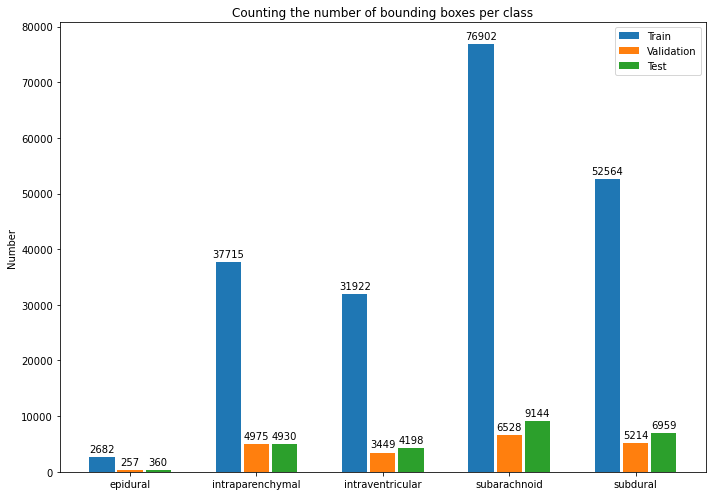

In [57]:
# Counting the number of bounding boxes per class

labels = ['epidural', 'intraparenchymal', 'intraventricular', 'subarachnoid', 'subdural']
train_class_num = [train_0, train_1, train_2, train_3, train_4]
val_class_num = [val_0, val_1, val_2, val_3, val_4]
test_class_num = [test_0, test_1, test_2, test_3, test_4]

x = np.arange(len(labels))  # the label locations
width = 0.2  # the width of the bars

fig, ax = plt.subplots(figsize=(10,7))
rects_train = ax.bar(x - width*10/9, train_class_num, width, label='Train')
rects_val = ax.bar(x, val_class_num, width, label='Validation')
rects_test = ax.bar(x + width*10/9, test_class_num, width, label='Test')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Number')
ax.set_title('Counting the number of bounding boxes per class')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects_train)
autolabel(rects_val)
autolabel(rects_test)

fig.tight_layout()

plt.show()


In [11]:
for i, data in enumerate(val_generator):
    if i == 0:
        print(data['img'].shape, data['annot'].shape)
        break

torch.Size([12, 3, 512, 512]) torch.Size([12, 5, 5])


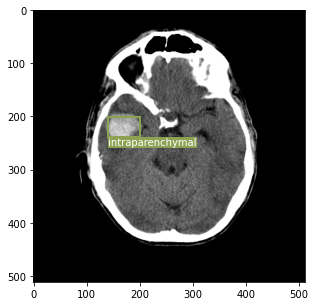

In [10]:
# Get specific val images
data = val_set.__getitem__(0) # Convert to 4d tensor (BxNxHxW)
val_image = data['img'].unsqueeze(0)
val_image = ((val_image - val_image.min()) / (val_image.max() - val_image.min()))

cmap = plt.get_cmap("tab20b")
colors = [cmap(i) for i in np.linspace(0, 1, len(params.obj_list))]
fig, ax0 = plt.subplots(figsize=(5,5))
for i in range(0,data['annot'].shape[0]):
    [x1,y1,x2,y2,cls] = data['annot'][i].numpy()
    color = colors[int(cls)]
    bbox = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=2, edgecolor=color, facecolor="none")
    ax0.add_patch(bbox)
    # Add label
    ax0.text(
        x1,
        y2,
        s=params.obj_list[int(cls)],
        color="white",
        verticalalignment="top", 
        bbox={"color": color, "pad": 0},
    )
    
ax0.imshow(val_image[0])
#ax0.axis('off')

# Visualization

The rest of the weights should be loaded already.


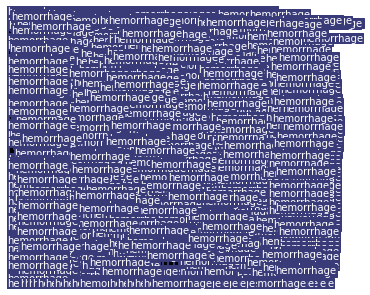

In [17]:
img_path = image_paths[0]
visualization(img_path)

# Optimizer

In [11]:
if opt['optim'] == 'adamw':
    optimizer = torch.optim.AdamW(model.parameters(), opt['lr'])
else:
    optimizer = torch.optim.SGD(model.parameters(), opt['lr'], momentum=0.9, nesterov=True)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, verbose=True)

# Train

In [11]:
epoch = 0
best_loss = 1e5
best_epoch = 0
step = max(0, last_step)
model.train()

num_iter_per_epoch = len(training_generator)
train_avg_losses = []
train_avg_cls_losses = []
train_avg_reg_losses = []
val_avg_losses = []
val_avg_cls_losses = []
val_avg_reg_losses = []

try:
    for epoch in range(opt['num_epochs']+1):
        last_epoch = step // num_iter_per_epoch
        if epoch < last_epoch:
            continue

        train_losses = []
        train_cls_losses = []
        train_reg_losses = []
        val_losses = []
        val_cls_losses = []
        val_reg_losses = []
        
        progress_bar = tqdm(training_generator)
        for iter, data in enumerate(progress_bar):
                
            imgs = data['img']
            annot = data['annot']

            if params.num_gpus == 1:
                # if only one gpu, just send it to cuda:0
                # elif multiple gpus, send it to multiple gpus in CustomDataParallel, not here
                imgs = imgs.cuda()
                annot = annot.cuda()
            
            optimizer.zero_grad()
            cls_loss, reg_loss = model(imgs, annot, obj_list=params.obj_list)
            cls_loss = cls_loss.mean()
            reg_loss = reg_loss.mean()

            loss = cls_loss + reg_loss
            if loss == 0 or not torch.isfinite(loss):
                continue

            loss.backward()
            # torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)
            optimizer.step()

            train_losses.append(loss.item())
            train_cls_losses.append(cls_loss.item())
            train_reg_losses.append(reg_loss.item())
            
            progress_bar.set_description(
               'Step: {}. Epoch: {}/{}. Iteration: {}/{}. Cls loss: {:.5f}. Reg loss: {:.5f}. Total loss: {:.5f}'.format(
                   step, epoch, opt['num_epochs'], iter + 1, num_iter_per_epoch, cls_loss.item(),
                   reg_loss.item(), loss.item()))
            
            step += 1

            #if step % opt['save_interval'] == 0 and step > 0:
            #    save_checkpoint(model, 'efficientdet-d{}_{}_{}.pth'.format(opt['compound_coef'],epoch,step))
            #    print('checkpoint...')
        
        train_avg_loss = torch.mean(torch.FloatTensor(train_losses))
        train_avg_losses.append(train_avg_loss.item())
        train_avg_cls_loss = torch.mean(torch.FloatTensor(train_cls_losses))
        train_avg_cls_losses.append(train_avg_cls_loss.item())        
        train_avg_reg_loss = torch.mean(torch.FloatTensor(train_reg_losses))
        train_avg_reg_losses.append(train_avg_reg_loss.item())               
        
        writer.add_scalars('Loss', {'train': train_avg_loss}, epoch)
        writer.add_scalars('Regression_loss', {'train': train_avg_reg_loss}, epoch)
        writer.add_scalars('Classfication_loss', {'train': train_avg_cls_loss}, epoch)
        
        # log learning_rate
        current_lr = optimizer.param_groups[0]['lr']
        writer.add_scalar('learning_rate', current_lr, epoch)          

        scheduler.step(train_avg_loss)

        model.eval()
        with torch.no_grad():
            for iter, data in enumerate(val_generator):
                imgs = data['img']
                annot = data['annot']

                if params.num_gpus == 1:
                    # if only one gpu, just send it to cuda:0
                    # elif multiple gpus, send it to multiple gpus in CustomDataParallel, not here
                    imgs = imgs.cuda()
                    annot = annot.cuda()

                cls_loss, reg_loss = model(imgs, annot, obj_list=params.obj_list)
                cls_loss = cls_loss.mean()
                reg_loss = reg_loss.mean()
                
                loss = cls_loss + reg_loss

                if loss == 0 or not torch.isfinite(loss):
                    continue
                
                val_losses.append(loss.item())
                val_cls_losses.append(cls_loss.item())
                val_reg_losses.append(reg_loss.item())
                      
        val_avg_loss = torch.mean(torch.FloatTensor(val_losses))
        val_avg_losses.append(val_avg_loss.item())
        val_avg_cls_loss = torch.mean(torch.FloatTensor(val_cls_losses))
        val_avg_cls_losses.append(val_avg_cls_loss.item())
        val_avg_reg_loss = torch.mean(torch.FloatTensor(val_reg_losses))
        val_avg_reg_losses.append(val_avg_reg_loss.item())

        print(
            'Val. Epoch: {}/{}. Classification loss: {:1.5f}. Regression loss: {:1.5f}. Total loss: {:1.5f}'.format(
                epoch, opt['num_epochs'], val_avg_cls_loss.item(), val_avg_reg_loss.item(), val_avg_loss.item()))
        
        writer.add_scalars('Loss', {'val': val_avg_loss}, epoch)
        writer.add_scalars('Regression_loss', {'val': val_avg_reg_loss}, epoch)
        writer.add_scalars('Classfication_loss', {'val': val_avg_cls_loss}, epoch)
        
        if val_avg_loss + opt['es_min_delta'] < best_loss:
            best_loss = val_avg_loss
            best_epoch = epoch

            save_checkpoint(model, 'efficientdet-d{}_{}_{}.pth'.format(opt['compound_coef'],epoch,step))

        model.train()
        
        # Early stopping
        if epoch - best_epoch > opt['es_patience'] > 0:
            print('[Info] Stop training at epoch {}. The lowest loss achieved is {}'.format(epoch, best_loss))
            break
                
except KeyboardInterrupt:
    save_checkpoint(model, 'efficientdet-d{}_{}_{}.pth'.format(opt['compound_coef'], epoch, step))
    writer.close()
writer.close()    


Val. Epoch: 0/600. Classification loss: 0.48404. Regression loss: 1.79136. Total loss: 2.27539



Val. Epoch: 1/600. Classification loss: 0.44953. Regression loss: 1.77123. Total loss: 2.22077



Val. Epoch: 2/600. Classification loss: 0.36592. Regression loss: 1.64913. Total loss: 2.01505



Val. Epoch: 3/600. Classification loss: 0.44625. Regression loss: 1.75070. Total loss: 2.19695



Val. Epoch: 4/600. Classification loss: 0.39998. Regression loss: 1.77913. Total loss: 2.17912



Val. Epoch: 5/600. Classification loss: 0.34459. Regression loss: 1.59981. Total loss: 1.94440



Val. Epoch: 6/600. Classification loss: 0.36794. Regression loss: 1.58096. Total loss: 1.94890



Val. Epoch: 7/600. Classification loss: 0.32132. Regression loss: 1.49836. Total loss: 1.81968



Val. Epoch: 8/600. Classification loss: 0.32581. Regression loss: 1.48508. Total loss: 1.81089



Val. Epoch: 9/600. Classification loss: 0.29752. Regression loss: 1.43967. Total loss: 1.73719



Val. Epoch: 10/600. Classification loss: 0.32069. Regression loss: 1.51242. Total loss: 1.83311



Val. Epoch: 11/600. Classification loss: 0.29850. Regression loss: 1.44132. Total loss: 1.73982



Val. Epoch: 12/600. Classification loss: 0.28681. Regression loss: 1.39964. Total loss: 1.68645



Val. Epoch: 13/600. Classification loss: 0.39985. Regression loss: 1.68328. Total loss: 2.08313



Val. Epoch: 14/600. Classification loss: 0.29256. Regression loss: 1.45419. Total loss: 1.74676



Val. Epoch: 15/600. Classification loss: 0.40137. Regression loss: 1.65772. Total loss: 2.05909



Val. Epoch: 16/600. Classification loss: 0.33697. Regression loss: 1.56739. Total loss: 1.90436



Val. Epoch: 17/600. Classification loss: 0.44372. Regression loss: 1.70833. Total loss: 2.15205



Val. Epoch: 18/600. Classification loss: 0.39295. Regression loss: 1.56764. Total loss: 1.96060



Val. Epoch: 19/600. Classification loss: 0.28991. Regression loss: 1.45493. Total loss: 1.74484



Val. Epoch: 20/600. Classification loss: 0.28609. Regression loss: 1.40992. Total loss: 1.69601



Val. Epoch: 21/600. Classification loss: 0.28994. Regression loss: 1.41332. Total loss: 1.70326



Val. Epoch: 22/600. Classification loss: 0.28686. Regression loss: 1.43480. Total loss: 1.72166



Val. Epoch: 23/600. Classification loss: 0.33162. Regression loss: 1.50619. Total loss: 1.83781



Val. Epoch: 24/600. Classification loss: 0.32020. Regression loss: 1.49980. Total loss: 1.82001



Val. Epoch: 25/600. Classification loss: 0.28454. Regression loss: 1.41237. Total loss: 1.69691



Val. Epoch: 26/600. Classification loss: 0.29892. Regression loss: 1.46307. Total loss: 1.76199



Val. Epoch: 27/600. Classification loss: 0.29977. Regression loss: 1.45229. Total loss: 1.75206



Val. Epoch: 28/600. Classification loss: 0.33655. Regression loss: 1.57384. Total loss: 1.91038



Val. Epoch: 29/600. Classification loss: 0.28799. Regression loss: 1.41512. Total loss: 1.70312



Val. Epoch: 30/600. Classification loss: 0.28532. Regression loss: 1.42612. Total loss: 1.71144



Val. Epoch: 31/600. Classification loss: 0.60618. Regression loss: 1.83918. Total loss: 2.44535



Val. Epoch: 32/600. Classification loss: 0.31233. Regression loss: 1.49924. Total loss: 1.81156



Val. Epoch: 33/600. Classification loss: 0.54610. Regression loss: 2.01953. Total loss: 2.56563



Val. Epoch: 34/600. Classification loss: 0.30801. Regression loss: 1.44742. Total loss: 1.75543



Val. Epoch: 35/600. Classification loss: 0.31923. Regression loss: 1.49426. Total loss: 1.81349



Val. Epoch: 36/600. Classification loss: 0.51754. Regression loss: 1.92267. Total loss: 2.44022



Val. Epoch: 37/600. Classification loss: 0.28738. Regression loss: 1.46033. Total loss: 1.74771



Val. Epoch: 38/600. Classification loss: 0.51772. Regression loss: 1.82332. Total loss: 2.34103



Val. Epoch: 39/600. Classification loss: 0.29077. Regression loss: 1.44447. Total loss: 1.73525



Val. Epoch: 40/600. Classification loss: 0.28221. Regression loss: 1.41716. Total loss: 1.69937



Val. Epoch: 41/600. Classification loss: 0.50536. Regression loss: 1.80719. Total loss: 2.31255



Val. Epoch: 42/600. Classification loss: 0.29298. Regression loss: 1.41402. Total loss: 1.70701



Val. Epoch: 43/600. Classification loss: 0.74023. Regression loss: 1.99766. Total loss: 2.73789



Val. Epoch: 44/600. Classification loss: 0.32417. Regression loss: 1.45402. Total loss: 1.77819



Val. Epoch: 45/600. Classification loss: 0.35537. Regression loss: 1.61817. Total loss: 1.97354



Val. Epoch: 46/600. Classification loss: 0.29219. Regression loss: 1.44494. Total loss: 1.73713



Val. Epoch: 47/600. Classification loss: 0.28864. Regression loss: 1.41067. Total loss: 1.69931



Val. Epoch: 48/600. Classification loss: 0.28310. Regression loss: 1.41671. Total loss: 1.69981



Val. Epoch: 49/600. Classification loss: 0.30306. Regression loss: 1.47399. Total loss: 1.77705



Val. Epoch: 50/600. Classification loss: 0.35963. Regression loss: 1.66022. Total loss: 2.01985



Val. Epoch: 51/600. Classification loss: 0.30560. Regression loss: 1.49798. Total loss: 1.80358



Val. Epoch: 52/600. Classification loss: 0.28339. Regression loss: 1.45067. Total loss: 1.73406



Val. Epoch: 53/600. Classification loss: 0.35064. Regression loss: 1.65428. Total loss: 2.00492



Val. Epoch: 54/600. Classification loss: 0.80043. Regression loss: 2.20120. Total loss: 3.00163



Val. Epoch: 55/600. Classification loss: 0.33631. Regression loss: 1.57134. Total loss: 1.90764



Val. Epoch: 56/600. Classification loss: 0.30910. Regression loss: 1.51648. Total loss: 1.82557



Val. Epoch: 57/600. Classification loss: 0.44947. Regression loss: 1.88525. Total loss: 2.33472



Val. Epoch: 58/600. Classification loss: 0.57497. Regression loss: 2.09123. Total loss: 2.66620



Val. Epoch: 59/600. Classification loss: 0.55893. Regression loss: 1.71793. Total loss: 2.27687



Val. Epoch: 60/600. Classification loss: 0.30810. Regression loss: 1.51235. Total loss: 1.82045



Val. Epoch: 61/600. Classification loss: 0.29876. Regression loss: 1.48470. Total loss: 1.78345



Val. Epoch: 62/600. Classification loss: 0.38984. Regression loss: 1.77768. Total loss: 2.16752



Val. Epoch: 63/600. Classification loss: 0.29376. Regression loss: 1.49361. Total loss: 1.78737



Val. Epoch: 64/600. Classification loss: 0.41475. Regression loss: 1.66762. Total loss: 2.08238



Val. Epoch: 65/600. Classification loss: 0.40331. Regression loss: 1.72654. Total loss: 2.12985



Val. Epoch: 66/600. Classification loss: 0.28247. Regression loss: 1.44197. Total loss: 1.72444



Val. Epoch: 67/600. Classification loss: 0.31405. Regression loss: 1.55953. Total loss: 1.87358



Val. Epoch: 68/600. Classification loss: 0.32943. Regression loss: 1.60422. Total loss: 1.93365



Val. Epoch: 69/600. Classification loss: 0.43454. Regression loss: 1.58299. Total loss: 2.01753



Val. Epoch: 70/600. Classification loss: 0.30164. Regression loss: 1.44634. Total loss: 1.74799



Val. Epoch: 71/600. Classification loss: 0.30792. Regression loss: 1.54010. Total loss: 1.84802



Val. Epoch: 72/600. Classification loss: 0.31724. Regression loss: 1.56330. Total loss: 1.88054



Val. Epoch: 73/600. Classification loss: 0.29261. Regression loss: 1.48745. Total loss: 1.78006



Val. Epoch: 74/600. Classification loss: 0.31953. Regression loss: 1.51948. Total loss: 1.83901



Val. Epoch: 75/600. Classification loss: 0.33454. Regression loss: 1.55494. Total loss: 1.88947



Val. Epoch: 76/600. Classification loss: 0.30487. Regression loss: 1.52213. Total loss: 1.82699



Val. Epoch: 77/600. Classification loss: 0.31785. Regression loss: 1.59048. Total loss: 1.90833



Val. Epoch: 78/600. Classification loss: 0.28826. Regression loss: 1.48832. Total loss: 1.77658



Val. Epoch: 79/600. Classification loss: 0.29003. Regression loss: 1.48316. Total loss: 1.77319



Val. Epoch: 80/600. Classification loss: 0.30866. Regression loss: 1.46568. Total loss: 1.77434



Val. Epoch: 81/600. Classification loss: 0.28835. Regression loss: 1.47545. Total loss: 1.76380



Val. Epoch: 82/600. Classification loss: 0.55784. Regression loss: 1.76225. Total loss: 2.32008



Val. Epoch: 83/600. Classification loss: 0.29347. Regression loss: 1.53239. Total loss: 1.82586



Val. Epoch: 84/600. Classification loss: 0.28615. Regression loss: 1.49109. Total loss: 1.77725



Val. Epoch: 85/600. Classification loss: 0.29552. Regression loss: 1.52465. Total loss: 1.82017



Val. Epoch: 86/600. Classification loss: 0.69171. Regression loss: 1.92789. Total loss: 2.61959



Val. Epoch: 87/600. Classification loss: 0.30423. Regression loss: 1.48719. Total loss: 1.79142



Val. Epoch: 88/600. Classification loss: 0.29278. Regression loss: 1.50454. Total loss: 1.79732



Val. Epoch: 89/600. Classification loss: 0.29380. Regression loss: 1.51687. Total loss: 1.81067



Val. Epoch: 90/600. Classification loss: 0.55352. Regression loss: 1.95301. Total loss: 2.50654



Val. Epoch: 91/600. Classification loss: 0.28519. Regression loss: 1.49240. Total loss: 1.77759



Val. Epoch: 92/600. Classification loss: 0.58759. Regression loss: 2.15533. Total loss: 2.74293



Val. Epoch: 93/600. Classification loss: 0.60228. Regression loss: 2.15302. Total loss: 2.75530



Val. Epoch: 94/600. Classification loss: 0.31256. Regression loss: 1.59349. Total loss: 1.90605



Val. Epoch: 95/600. Classification loss: 0.61655. Regression loss: 2.05276. Total loss: 2.66931



Val. Epoch: 96/600. Classification loss: 0.28618. Regression loss: 1.49587. Total loss: 1.78205



Val. Epoch: 97/600. Classification loss: 0.29269. Regression loss: 1.49179. Total loss: 1.78449



Val. Epoch: 98/600. Classification loss: 0.29441. Regression loss: 1.48180. Total loss: 1.77622



Val. Epoch: 99/600. Classification loss: 0.56034. Regression loss: 2.09411. Total loss: 2.65445



Val. Epoch: 100/600. Classification loss: 0.31729. Regression loss: 1.58958. Total loss: 1.90687



Val. Epoch: 101/600. Classification loss: 0.28640. Regression loss: 1.47388. Total loss: 1.76027



Val. Epoch: 102/600. Classification loss: 0.40799. Regression loss: 1.90981. Total loss: 2.31780



Val. Epoch: 103/600. Classification loss: 0.37806. Regression loss: 1.79753. Total loss: 2.17559



Val. Epoch: 104/600. Classification loss: 0.30474. Regression loss: 1.52228. Total loss: 1.82701



Val. Epoch: 105/600. Classification loss: 0.67364. Regression loss: 2.36173. Total loss: 3.03537



Val. Epoch: 106/600. Classification loss: 0.28906. Regression loss: 1.51694. Total loss: 1.80601



Val. Epoch: 107/600. Classification loss: 0.29965. Regression loss: 1.53867. Total loss: 1.83832



Val. Epoch: 108/600. Classification loss: 0.54809. Regression loss: 2.11472. Total loss: 2.66281



Val. Epoch: 109/600. Classification loss: 0.30442. Regression loss: 1.59462. Total loss: 1.89903



Val. Epoch: 110/600. Classification loss: 0.29371. Regression loss: 1.52415. Total loss: 1.81787



Val. Epoch: 111/600. Classification loss: 0.42415. Regression loss: 1.89457. Total loss: 2.31873



Val. Epoch: 112/600. Classification loss: 0.57160. Regression loss: 1.76169. Total loss: 2.33328



Val. Epoch: 113/600. Classification loss: 0.36177. Regression loss: 1.75429. Total loss: 2.11606



Val. Epoch: 114/600. Classification loss: 0.62673. Regression loss: 1.73841. Total loss: 2.36514



Val. Epoch: 115/600. Classification loss: 0.32167. Regression loss: 1.61857. Total loss: 1.94025



Val. Epoch: 116/600. Classification loss: 0.30634. Regression loss: 1.52424. Total loss: 1.83058



Val. Epoch: 117/600. Classification loss: 0.60132. Regression loss: 2.24173. Total loss: 2.84305



Val. Epoch: 118/600. Classification loss: 0.31469. Regression loss: 1.55831. Total loss: 1.87300



Val. Epoch: 119/600. Classification loss: 0.52820. Regression loss: 1.81313. Total loss: 2.34133



Val. Epoch: 120/600. Classification loss: 0.98806. Regression loss: 1.89628. Total loss: 2.88434



Val. Epoch: 121/600. Classification loss: 0.28950. Regression loss: 1.49690. Total loss: 1.78640



Val. Epoch: 122/600. Classification loss: 0.35121. Regression loss: 1.69115. Total loss: 2.04236



Val. Epoch: 123/600. Classification loss: 0.34913. Regression loss: 1.64470. Total loss: 1.99383



Val. Epoch: 124/600. Classification loss: 0.29875. Regression loss: 1.50371. Total loss: 1.80246



Val. Epoch: 125/600. Classification loss: 0.30805. Regression loss: 1.54090. Total loss: 1.84895



Val. Epoch: 126/600. Classification loss: 0.37135. Regression loss: 1.66110. Total loss: 2.03245



Val. Epoch: 127/600. Classification loss: 0.29550. Regression loss: 1.50498. Total loss: 1.80047



Val. Epoch: 128/600. Classification loss: 0.32943. Regression loss: 1.59483. Total loss: 1.92426



Val. Epoch: 129/600. Classification loss: 0.33423. Regression loss: 1.68724. Total loss: 2.02146



Val. Epoch: 130/600. Classification loss: 0.68902. Regression loss: 2.27473. Total loss: 2.96375



Val. Epoch: 131/600. Classification loss: 0.29598. Regression loss: 1.52160. Total loss: 1.81758



Val. Epoch: 132/600. Classification loss: 0.29729. Regression loss: 1.55794. Total loss: 1.85523



Val. Epoch: 133/600. Classification loss: 0.30801. Regression loss: 1.57310. Total loss: 1.88111



Val. Epoch: 134/600. Classification loss: 0.29375. Regression loss: 1.51645. Total loss: 1.81020



Val. Epoch: 135/600. Classification loss: 0.31135. Regression loss: 1.55362. Total loss: 1.86497



Val. Epoch: 136/600. Classification loss: 0.30713. Regression loss: 1.56102. Total loss: 1.86815



Val. Epoch: 137/600. Classification loss: 0.31342. Regression loss: 1.56775. Total loss: 1.88117



Val. Epoch: 138/600. Classification loss: 0.64296. Regression loss: 2.17816. Total loss: 2.82112



Val. Epoch: 139/600. Classification loss: 0.31269. Regression loss: 1.56075. Total loss: 1.87344



Val. Epoch: 140/600. Classification loss: 0.35285. Regression loss: 1.59164. Total loss: 1.94449



Val. Epoch: 141/600. Classification loss: 0.49495. Regression loss: 2.12023. Total loss: 2.61518



Val. Epoch: 142/600. Classification loss: 0.50004. Regression loss: 1.82007. Total loss: 2.32010



Val. Epoch: 143/600. Classification loss: 0.30025. Regression loss: 1.49287. Total loss: 1.79311



Val. Epoch: 144/600. Classification loss: 0.29754. Regression loss: 1.54452. Total loss: 1.84205


# Restore Checkpoint

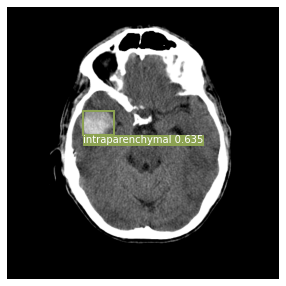

In [12]:
img_path = val_image_paths[0]
weight_path = "./logs/hemorrhage/efficientdet-d0_12_93405.pth"
visualization(img_path, weight_path, 0.1, 0.1)

In [ ]:
save_result(test_image_paths, 1000, 0.1, 0.1)

# Evaluation

In [27]:
# Bouinding box evaluation
metric_fn = eval_bbox(
    test_image_paths, test_mask_paths, weight_path, len(params.obj_list), 0.1, 0.1)

In [58]:
# All class evaluation
tp, fp, tn, fn = eval_class(test_image_paths, len(test_image_paths), weight_path, 0.1, 0.1)

In [85]:
# epidural evaluaion
tp, fp, tn, fn = eval_each_class(test_image_paths, len(test_image_paths), weight_path, 0, 0.1, 0.1)

In [86]:
# intraparenchymal evaluation
tp, fp, tn, fn = eval_each_class(test_image_paths, len(test_image_paths), weight_path, 1, 0.1, 0.1)

In [87]:
# intraventricular evaluation
tp, fp, tn, fn = eval_each_class(test_image_paths, len(test_image_paths), weight_path, 2, 0.1, 0.1)

In [88]:
# subarachnoid evaluation
tp, fp, tn, fn = eval_each_class(test_image_paths, len(test_image_paths), weight_path, 3, 0.1, 0.1)

In [92]:
# subdural evaluation
tp, fp, tn, fn = eval_each_class(test_image_paths, len(test_image_paths), weight_path, 4, 0.1, 0.1)